In [1]:
import koopman_g1 as kg1
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os

from Utility import (
    load_koopman_model,
    recover_single_control,
    recover_controls_for_trajectory
)

INFO:drake:Meshcat listening for connections at http://localhost:7000
/home/yuyang-pang/miniconda3/envs/koopman/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
env_name = 'g1'
Data_collect = kg1.data_collecter(env_name)
udim = Data_collect.udim
Nstates = Data_collect.Nstates
dicts = torch.load('best_model_g1.pth')
state_dict = dicts['model']
layer = dicts['layer']
NKoopman = layer[-1] + Nstates
net = kg1.Network(layer, NKoopman, udim)
net.load_state_dict(state_dict)
net.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.cuda()
net.double()
Samples = 5000
steps = 30
times = 4
max_loss_all = np.zeros((times,steps))
mean_loss_all = np.zeros((times,steps))
with torch.no_grad():
    for i in range(times):
        test_data_path = "{}{}.npy".format(env_name,i)
        if os.path.exists(test_data_path):
            test_data = np.load("{}{}.npy".format(env_name,i))
        else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("{}{}.npy".format(env_name,i),test_data)
        test_data = np.load("{}{}.npy".format(env_name, i))
        max_loss,mean_loss = kg1.K_loss(test_data,net,udim,Nstate=Nstates)
        max_loss_all[i] = max_loss.reshape(-1)
        mean_loss_all[i] = mean_loss.reshape(-1)
max_mean = np.mean(max_loss_all,axis=0)
max_std = np.std(max_loss_all,axis=0)
mean_mean =  np.mean(mean_loss_all,axis=0)
mean_std =  np.std(mean_loss_all,axis=0)
np.save(env_name+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))

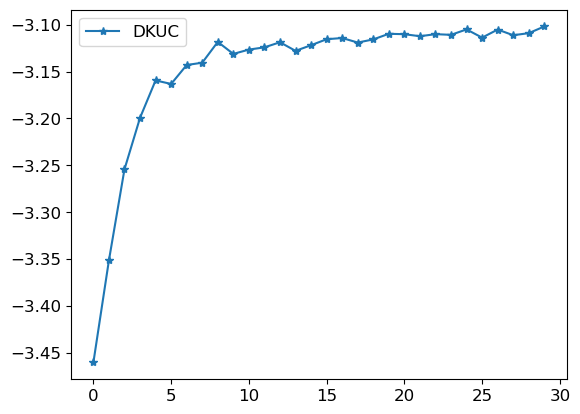

In [3]:
font = {'size': 12}
plt.rc('font', **font)
file_path = env_name + ".npy"
data = np.load(file_path)
plt.plot(np.log10(data[0]),'*-',color = '#1f77b4',label='DKUC',linewidth=1.5)
plt.legend()


In [4]:
test_data = Data_collect.collect_koopman_data(1, 30)
test_data.shape

(31, 1, 21)

In [5]:
current_state = test_data[0, 0, udim:]
x_1_state = test_data[1, 0, udim:]
print(current_state.shape)
print(x_1_state.shape)

(14,)
(14,)


In [6]:
pth_file = 'best_model_g1.pth'
net = load_koopman_model(pth_file, device)
u0 = recover_single_control(current_state, x_1_state, net, device)
print("Recovered control: ", u0)

Recovered control:  tensor([ 17.5901,   6.7051,  -7.5111, -14.4400, -23.4018,  -1.3207,  -1.6496],
       device='cuda:0', dtype=torch.float64)


In [7]:
controls = recover_controls_for_trajectory(test_data[:, 0, udim:], net, device)

In [10]:
controls.shape

torch.Size([30, 7])